In [18]:
# Setup
import sys; sys.path.insert(0, '/mnt/home/mlee1/vdm_BIND')
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning.pytorch import seed_everything, Trainer

seed_everything(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Seed set to 42


Device: cuda


---
## 1. The Core API: One Line to Create Any Model

```python
model = create_method(METHOD, backbone_type=BACKBONE, ...)
```

In [19]:
from vdm.methods import create_method, list_methods
from vdm.backbones import list_backbones

print("Methods:", list_methods())
print("Backbones:", list_backbones())

Methods: ['consistency', 'dsm', 'flow', 'ot_flow', 'vdm']
Backbones: ['dit', 'dit-b', 'dit-l', 'dit-s', 'dit-xl', 'fno', 'fno-b', 'fno-l', 'fno-s', 'fno-xl', 'unet', 'unet-b', 'unet-l', 'unet-s']


In [20]:
# Create any combination in ONE LINE:
vdm_unet = create_method('vdm', backbone_type='unet-s', img_size=128, param_dim=6)
flow_dit = create_method('flow', backbone_type='dit-s', img_size=128, param_dim=6)
cons_fno = create_method('consistency', backbone_type='fno-s', img_size=128, param_dim=6)

for name, m in [('VDM+UNet', vdm_unet), ('Flow+DiT', flow_dit), ('Consistency+FNO', cons_fno)]:
    print(f"{name}: {sum(p.numel() for p in m.parameters()):,} params")


INITIALIZED DiT MODEL
  Image size: 128x128
  Patch size: 4
  Num patches: 1024
  Hidden size: 384
  Depth: 12
  Heads: 6
  MLP ratio: 4.0
  Parameters: 6 (0=unconditional)
  Conditioning: 1 + 3 large-scale
  Total params: 32,674,224

VDM+UNet: 10,540,683 params
Flow+DiT: 32,674,224 params
Consistency+FNO: 2,147,267 params


---
## 2. Load Data

In [21]:
from config import TRAIN_DATA_ROOT, QUANTILE_TRANSFORMER
from vdm.astro_dataset import get_astro_data

datamodule = get_astro_data(
    dataset='IllustrisTNG',
    data_root=str(TRAIN_DATA_ROOT),
    batch_size=32,
    limit_train_samples=500,  # Small for demo
    limit_val_samples=100,
    quantile_path=QUANTILE_TRANSFORMER,
)
datamodule.setup()
print(f"Train: {len(datamodule.train_data)}, Val: {len(datamodule.valid_data)}")

✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
📂 Loading file list from

In [22]:
# Get a batch: (condition, large_scale, target, params)
condition, large_scale, target, params = next(iter(datamodule.train_dataloader()))
full_cond = torch.cat([condition, large_scale], dim=1)  # Combine for model input

print(f"Input: condition {condition.shape} + large_scale {large_scale.shape} = {full_cond.shape}")
print(f"Target: {target.shape} (DM_hydro, Gas, Stars)")
print(f"Params: {params.shape}")

Input: condition torch.Size([32, 1, 128, 128]) + large_scale torch.Size([32, 3, 128, 128]) = torch.Size([32, 4, 128, 128])
Target: torch.Size([32, 3, 128, 128]) (DM_hydro, Gas, Stars)
Params: torch.Size([32, 35])


---
## 3. Train: Any Method + Any Backbone

All methods are PyTorch Lightning modules - just call `trainer.fit(model, datamodule)`

In [42]:
# Create model with actual param_dim from data
model = create_method('vdm', backbone_type='dit-b', img_size=128, param_dim=params.shape[1])

# Train!
trainer = Trainer(max_epochs=10, accelerator='gpu' if device=='cuda' else 'cpu', 
                  devices=1, logger=False, enable_checkpointing=False,
                  limit_train_batches=10, limit_val_batches=2)  # Quick demo
trainer.fit(model, datamodule)


INITIALIZED DiT MODEL
  Image size: 128x128
  Patch size: 4
  Num patches: 1024
  Hidden size: 768
  Depth: 12
  Heads: 12
  MLP ratio: 4.0
  Parameters: 35 (0=unconditional)
  Conditioning: 1 + 3 large-scale
  Total params: 130,251,312


VDM METHOD INITIALIZED
  Backbone: DiTBackbone
  Gamma range: [-13.3, 5.0]
  Noise schedule: fixed_linear
  Sampling steps: 250
  Channel weights: (1.0, 1.0, 1.0)
  Focal loss: False



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.


📂 Loading file list from cache: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/file_list_cache.txt
   Loaded 451580 files in 0.10s
Found 451580 total files
⚡ FAST ABLATION MODE: Randomly selecting 500 training samples
  → Selected 500 random samples from full dataset



  | Name     | Type                | Params | Mode 
---------------------------------------------------------
0 | backbone | DiTBackbone         | 130 M  | train
1 | gamma    | FixedLinearSchedule | 0      | train
---------------------------------------------------------
130 M     Trainable params
0         Non-trainable params
130 M     Total params
521.005   Total estimated model params size (MB)
214       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


---
## 4. Sample: Generate New Fields

In [43]:
# Generate samples from one conditioning input
model.eval().to(device)
cond = full_cond[:1].to(device)  # Single condition
p = params[:1].to(device)

with torch.no_grad():
    samples = model.draw_samples(cond.expand(4,-1,-1,-1), batch_size=4, 
                                  n_sampling_steps=50, conditional_params=p.expand(4,-1))
print(f"Generated: {samples.shape}")

Generated: torch.Size([4, 3, 128, 128])


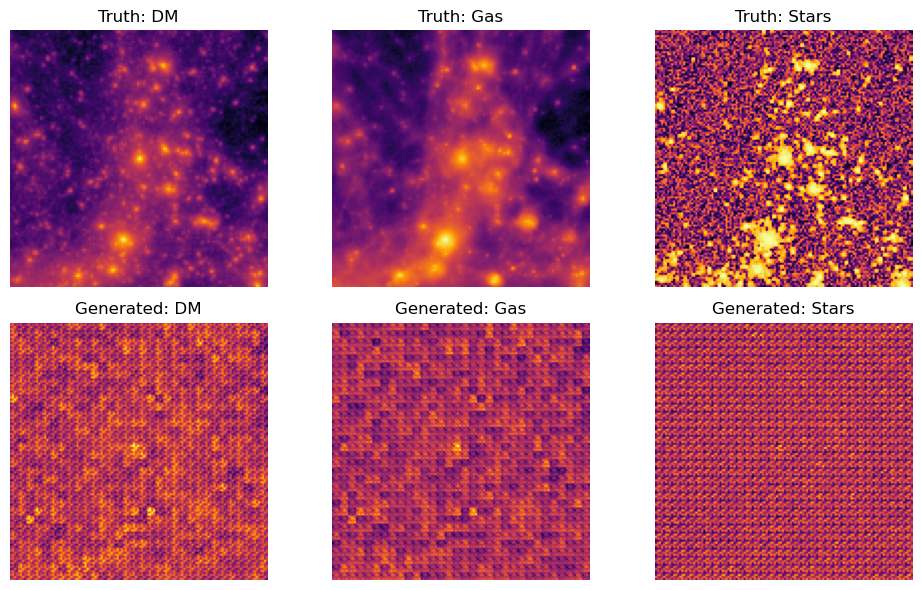

In [44]:
# Quick visualization
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
for c, name in enumerate(['DM', 'Gas', 'Stars']):
    ax[0,c].imshow(target[0,c], cmap='inferno'); ax[0,c].set_title(f'Truth: {name}')
    ax[1,c].imshow(samples[0,c].cpu(), cmap='inferno'); ax[1,c].set_title(f'Generated: {name}')
[a.axis('off') for a in ax.flat]; plt.tight_layout(); plt.show()

---
## 5. Compare Methods: Same Backbone, Different Training

This is the power of the modular design - easy ablation studies!

In [ ]:
# Compare all 5 methods with same backbone (quiet mode)
from vdm.backbones import set_verbose

set_verbose(False)  # Disable init messages for cleaner output

x = target[:4].to(device)
c = full_cond[:4].to(device)
p = params[:4].to(device)

print("Loss comparison (same UNet-S backbone):")
print("-" * 40)
for method in ['vdm', 'flow', 'consistency', 'dsm', 'ot_flow']:
    m = create_method(method, backbone_type='unet-s', img_size=128, param_dim=35).to(device)
    loss, _ = m.compute_loss(x, c, p)
    print(f"{method:12s}: {loss.item():.4f}")

set_verbose(True)  # Re-enable for subsequent cells

Loss comparison (same UNet-S backbone):
----------------------------------------
vdm         : 7.5225
flow        : 0.2836


consistency : 0.7243
dsm         : 22.8919
ot_flow     : 0.3979


---
## 6. Config Factory: Generate Training Configs

For command-line training with `train_zoo.py`:

In [30]:
from configs.config_factory import ConfigFactory

# Create and save a config
config = ConfigFactory.create(method='flow', backbone='dit-s', batch_size=64, max_epochs=100)
config.save('/mnt/home/mlee1/vdm_BIND/configs/flow_dit_example.ini')
print("Config saved! Train with: python train_zoo.py --config configs/flow_dit_example.ini")

✓ Config saved to: /mnt/home/mlee1/vdm_BIND/configs/flow_dit_example.ini
Config saved! Train with: python train_zoo.py --config configs/flow_dit_example.ini


---
## Command Line Training

```bash
# Quick start - auto config
python train_zoo.py --method vdm --backbone unet-s

# With saved config
python train_zoo.py --config configs/flow_dit_example.ini

# Fast consistency model
python train_zoo.py --method consistency --backbone fno-s --n_sampling_steps 1
```

---
## Summary

The Generative Zoo API makes it easy to:

1. **Create models**: `create_method('vdm', backbone_type='unet-s', ...)`
2. **Train**: `trainer.fit(model, datamodule)` 
3. **Sample**: `model.draw_samples(conditioning, ...)`
4. **Compare**: Loop over methods/backbones for ablations

All 5 methods × 10 backbones = **50 combinations** with the same API!